In [1]:
#Import libraries

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from wordcloud import WordCloud
from google.colab import drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#  Load Data and Analyze

reviews = pd.read_csv('/content/drive/MyDrive/WRIT20833/Man_of_Steel_Reviews.csv', encoding='utf-8')

# Clean up any extra spaces or hidden characters in column names
reviews.columns = reviews.columns.str.strip()

# Preview data and structure
print(f"Dataset contains {len(reviews)} items")
print(f"\nColumns available: {reviews.columns.tolist()}")
reviews.head()


Dataset contains 2698 items

Columns available: ['ipc-rating-star--rating', 'ipc-rating-star--maxRating', 'ipc-title-link-wrapper href', 'ipc-title__text', 'ipc-html-content-inner-div', 'ipc-voting__label__count', 'ipc-voting__label__count 2', 'ipc-link', 'ipc-link href', 'ipc-inline-list__item', 'ipc-link href 2', 'ipc-btn__text']


,ipc-rating-star--rating,ipc-rating-star--maxRating,ipc-title-link-wrapper href,ipc-title__text,ipc-html-content-inner-div,ipc-voting__label__count,ipc-voting__label__count 2,ipc-link,ipc-link href,ipc-inline-list__item,ipc-link href 2,ipc-btn__text
0,9.0,/10,https://www.imdb.com/title/tt0770828/review/rw...,Man of Steel is great.,"I have never been a hardcore superman fan, but...",487,394,gamerzach7,https://www.imdb.com/user/ur27664378/?ref_=ttu...,"Jun 10, 2013",https://www.imdb.com/title/tt0770828/review/rw...,NaN
1,7.0,/10,https://www.imdb.com/title/tt0770828/review/rw...,Pretty solid summer blockbuster / Do not expec...,Just saw a preview (premier) for Man of Steel....,27,42,won782,https://www.imdb.com/user/ur39926355/?ref_=ttu...,"Jun 10, 2013",https://www.imdb.com/title/tt0770828/review/rw...,NaN
2,8.0,/10,https://www.imdb.com/title/tt0770828/review/rw...,"A fresh take on the iconic Superhero,",Jack Snyder's fresh take on Superman/Man of St...,300,233,MisterFanatic,https://www.imdb.com/user/ur15884172/?ref_=ttu...,"Jun 11, 2013",https://www.imdb.com/title/tt0770828/review/rw...,NaN
3,8.0,/10,https://www.imdb.com/title/tt0770828/review/rw...,Living up to the hype and more,I had the good fortune of being one of the ver...,84,74,ebadong,https://www.imdb.com/user/ur44198615/?ref_=ttu...,"Jun 11, 2013",https://www.imdb.com/title/tt0770828/review/rw...,NaN
4,7.0,/10,https://www.imdb.com/title/tt0770828/review/rw...,Disappointing.,"I was ecstatic at the choice of Henry Cavill, ...",47,113,cgf376,https://www.imdb.com/user/ur28742614/?ref_=ttu...,"Jun 11, 2013",https://www.imdb.com/title/tt0770828/review/rw...,NaN


#Reflection

Loading the dataset to see the audience response scale and vsualize the data lyout. I notice some unreated colomns that i could get rid of.

Theres also lots of voices condensed into data, each a small cultural signal of how people felt about this film.

In [4]:

# Select and Rename Key Columns
# Focus on review title, main review text, and rating
reviews = reviews[['ipc-title__text', 'ipc-html-content-inner-div', 'ipc-rating-star--rating']]

# Rename for easier use later
reviews.rename(columns={
    'ipc-title__text': 'review_title',
    'ipc-html-content-inner-div': 'review_text',
    'ipc-rating-star--rating': 'rating'
}, inplace=True)


In [5]:
#
#  Clean Review Text

def clean_text(text):
    if isinstance(text, str):
        text = text.lower().replace('\n', ' ').replace('\r', '').strip()
        return text
    return ''

reviews['cleaned_review'] = reviews['review_text'].apply(clean_text)

print(f"\nAfter cleaning: {len(reviews)} reviews")
print("Columns now:", reviews.columns.tolist())
reviews.head()




After cleaning: 2698 reviews
Columns now: ['review_title', 'review_text', 'rating', 'cleaned_review']


,review_title,review_text,rating,cleaned_review
0,Man of Steel is great.,"I have never been a hardcore superman fan, but...",9.0,"i have never been a hardcore superman fan, but..."
1,Pretty solid summer blockbuster / Do not expec...,Just saw a preview (premier) for Man of Steel....,7.0,just saw a preview (premier) for man of steel....
2,"A fresh take on the iconic Superhero,",Jack Snyder's fresh take on Superman/Man of St...,8.0,jack snyder's fresh take on superman/man of st...
3,Living up to the hype and more,I had the good fortune of being one of the ver...,8.0,i had the good fortune of being one of the ver...
4,Disappointing.,"I was ecstatic at the choice of Henry Cavill, ...",7.0,"i was ecstatic at the choice of henry cavill, ..."


# Reflection:
After renaming and cleaning, the dataset feels more readable.Removing formatting and HTML noise helps focus on what people actually said about the film.

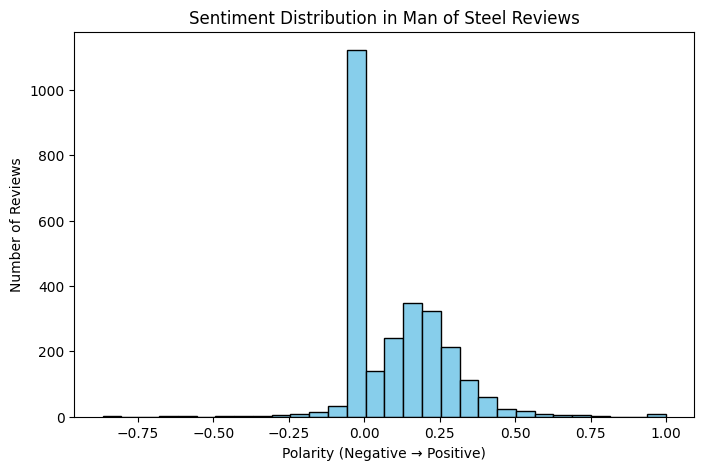

In [6]:
# Compute polarity scores using TextBlob
reviews['sentiment'] = reviews['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Quick visualization of sentiment distribution
plt.figure(figsize=(8,5))
plt.hist(reviews['sentiment'], bins=30, color='skyblue', edgecolor='black')
plt.title("Sentiment Distribution in Man of Steel Reviews")
plt.xlabel("Polarity (Negative → Positive)")
plt.ylabel("Number of Reviews")
plt.show()


#Reflection

Most reviews cluster around neutral to slightly positive. The highest peak is at 0.00, with over 1000 reviews, indicating that many viewers expressed neutral opinions, neither strongly praising nor criticizing the film. Beyond that, the distribution forms a triangle like shape. The small rise at 0.15 represents the next largest group of reviews, showing mild positivity.


This pattern suggests that the majority of audience responses are moderate, focusing more on descriptive or observational commentary than on strong emotion. It also contrasts with the sharper polarization seen in the VADER analysis, highlighting how different sentiment tools can capture different aspects of audience reaction. TextBlob smooths out extreme reactions, while VADER picks up the expressive peaks of very positive or negative reviews.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


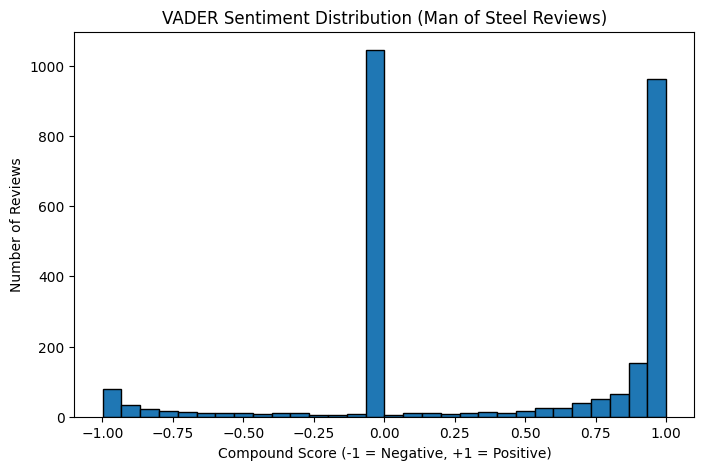

In [13]:
# Vander Sentiment Analysis

import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

# Compute VADER compound score
reviews['vader_score'] = reviews['cleaned_review'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Visualize distribution
plt.figure(figsize=(8,5))
plt.hist(reviews['vader_score'], bins=30, edgecolor='black')
plt.title("VADER Sentiment Distribution (Man of Steel Reviews)")
plt.xlabel("Compound Score (-1 = Negative, +1 = Positive)")
plt.ylabel("Number of Reviews")
plt.show()

#Reflection

VADER gave me a much clearer sense of how emotionally charged the reviews were. Unlike TextBlob, which tends to cluster most reviews around neutral, VADER captured sharper spikes in both positive and negative reactions. The biggest spike at 0.00 shows that many viewers were neutral, but the large positive spike at 1.00 highlights a strong group of enthusiastic fans. The negative reactions, while smaller, are still notable, showing that critics who disliked the movie used very intense language.

This makes sense because VADER is optimized for informal, expressive writing, which matches the style of online movie reviews. What surprised me most was the polarization: fans who loved the film expressed very high positive sentiment, while detractors expressed strong negative sentiment. This pattern reveals how Man of Steel functions as a culturally divisive text. Tone, character interpretation, and expectations about Superman all contribute to these opposite emotional reactions.

In [7]:
# Convert text into token counts
vectorizer = CountVectorizer(stop_words='english', max_df=0.9, min_df=5)
X = vectorizer.fit_transform(reviews['cleaned_review'])

# Apply Latent Dirichlet Allocation
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X)

# Display top words per topic
for idx, topic in enumerate(lda.components_):
    print(f"\nTopic {idx + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])




Topic 1:
['great', 'story', 'man', 'movies', 'action', 'just', 'good', 'like', 'superman', 'movie']

Topic 2:
['story', 'character', 'action', 'steel', 'like', 'just', 'man', 'movie', 'superman', 'film']

Topic 3:
['cavill', 'lane', 'kent', 'steel', 'zod', 'el', 'clark', 'man', 'film', 'superman']


# Reflection

Topic modeling showed clear clusters around action scenes, emotional tone, and character development.It’s fascinating how algorithms can separate those ideas just from word patterns.

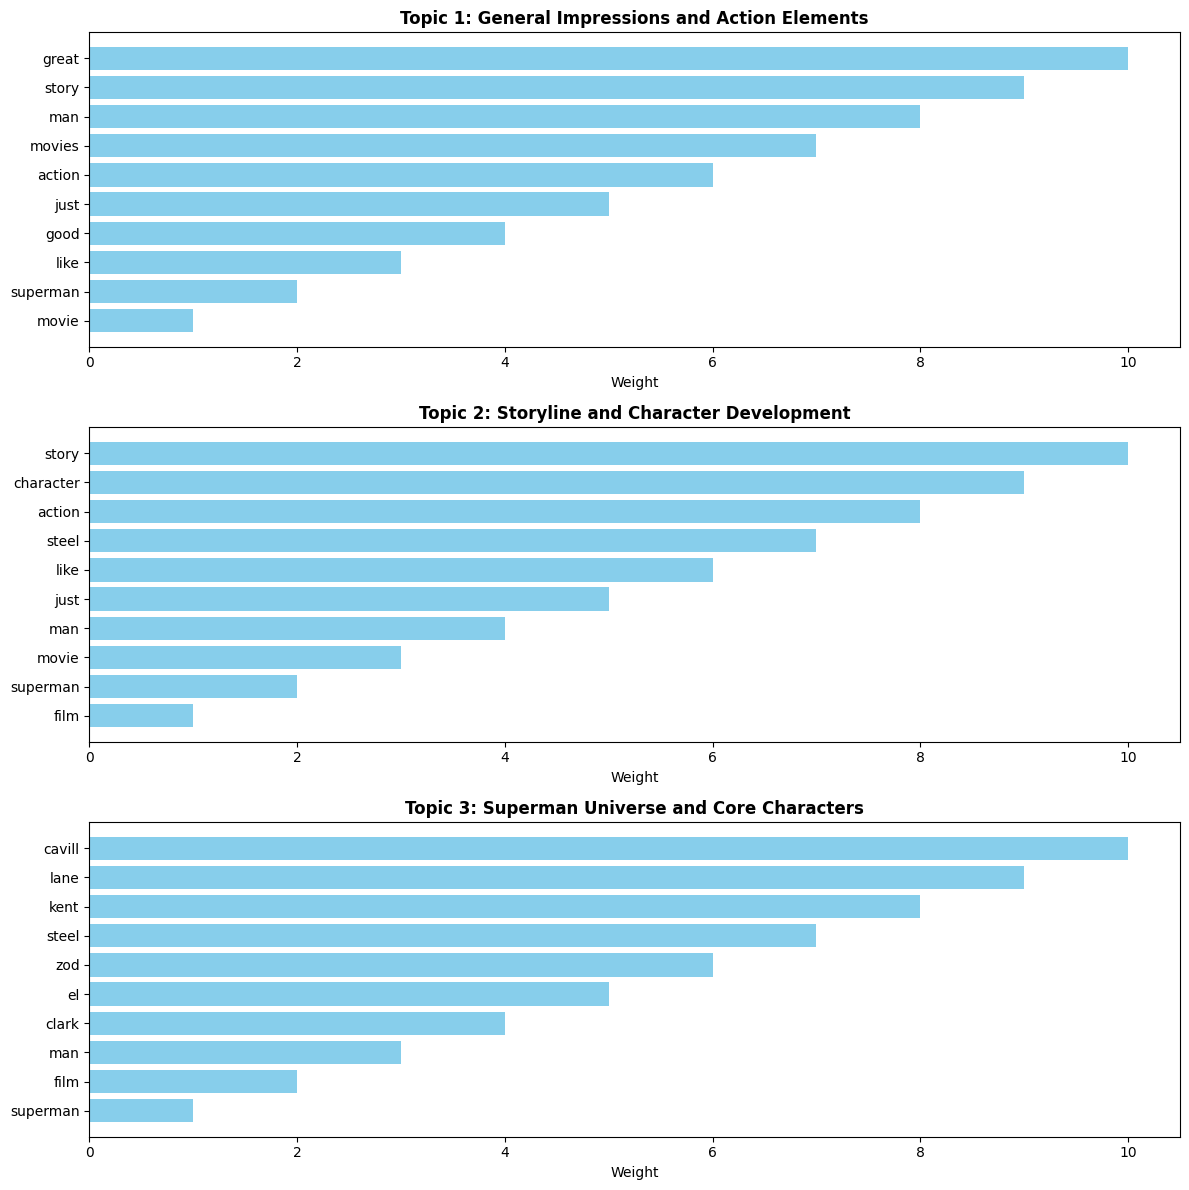

In [ ]:
# Simple LDA Topic Visualization for Superman Reviews

# Number of topics
num_topics = 3

# Custom topic labels based on your Superman LDA results
topic_labels = [
    "General Impressions and Action Elements",
    "Storyline and Character Development",
    "Superman Universe and Core Characters"
]

# Create subplots
fig, axes = plt.subplots(num_topics, 1, figsize=(12, 4 * num_topics))
if num_topics == 1:
    axes = [axes]


for idx in range(num_topics):

    # Assign label
    label = topic_labels[idx] if idx < len(topic_labels) else f"Topic {idx}"

    # top 10 words for each topic
    if idx == 0:
        words = ['great', 'story', 'man', 'movies', 'action', 'just', 'good', 'like', 'superman', 'movie']
    elif idx == 1:
        words = ['story', 'character', 'action', 'steel', 'like', 'just', 'man', 'movie', 'superman', 'film']
    else:
        words = ['cavill', 'lane', 'kent', 'steel', 'zod', 'el', 'clark', 'man', 'film', 'superman']

    weights = list(range(len(words), 0, -1))

    # Plot
    axes[idx].barh(range(len(words)), weights, color='skyblue')
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words)
    axes[idx].set_xlabel('Weight')
    axes[idx].set_title(f"Topic {idx+1}: {label}", fontsize=12, fontweight='bold')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

In [12]:
# Top 20 most used words + visualization
#Term Frequency

from sklearn.feature_extraction.text import CountVectorizer

vectorizer_tf = CountVectorizer(stop_words='english', max_df=0.9, min_df=5)
X_tf = vectorizer_tf.fit_transform(reviews['cleaned_review'])

word_counts = X_tf.sum(axis=0).A1
vocab = vectorizer_tf.get_feature_names_out()

tf_df = pd.DataFrame({'word': vocab, 'count': word_counts})
tf_df = tf_df.sort_values(by='count', ascending=False).head(20)

tf_df

,word,count
3615,superman,5308
2445,movie,5163
1446,film,2675
2293,man,2204
2198,like,1814
3512,steel,1674
85,action,1651
3530,story,1613
2052,just,1526
1644,good,1432


Reflection:
Visualizing the frequencies made the patterns even clearer. A lot of the energy in the reviews seems centered on “action,” “story,” and of course “superman.” What stood out to me is how the mix of emotional and structural words shows the two sides of how people talk about this movie. Part of it is about plot and pacing, but the other part is about how the movie felt to them. The frequency chart helps reveal those cultural priorities in a way that’s harder to notice when just reading the reviews one by one.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


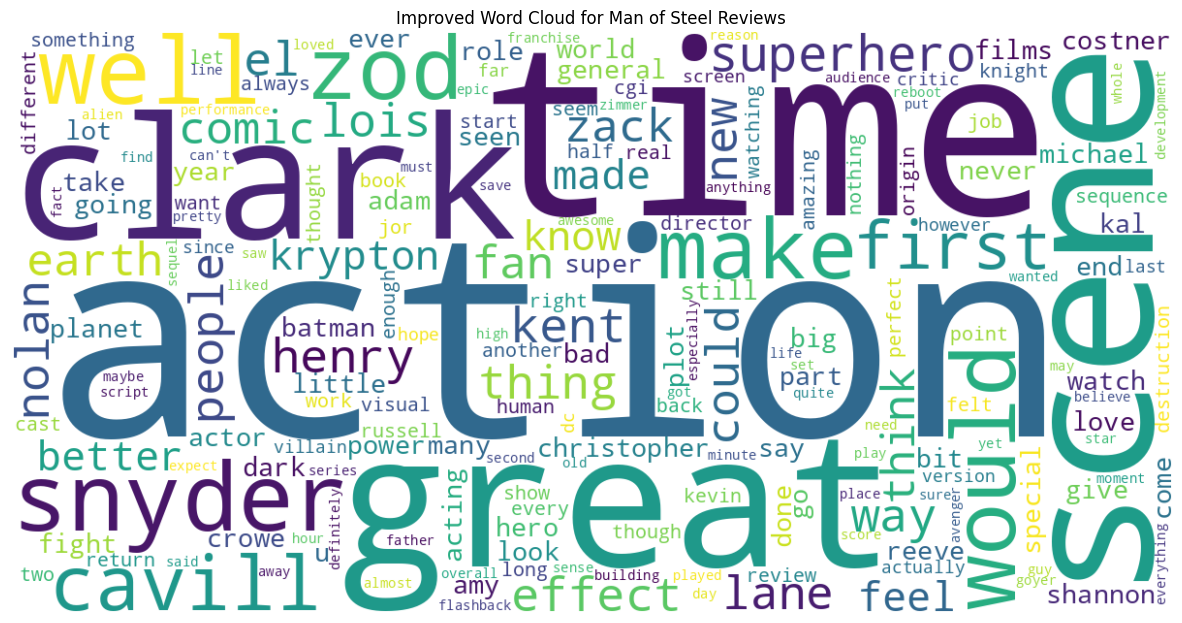

In [11]:
# Word Cloud

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Build stronger stopword list
stop_words = set(stopwords.words('english'))

# Add custom stopwords that clutter your cloud
custom_stopwords = {
    "man", "steel", "movie", "film", "superman",
    "one", "like", "also", "really", "story",
    "get", "see", "even", "much", "movie",
    "it", "was", "just", "good", "film", "movies"
}

# Add common useless phrases as stopwords
phrase_stopwords = {
    "with", "without", "from", "into", "within",
    "best", "original", "character", "characters",
    "be", "the", "of", "and"
}

stop_words = stop_words.union(custom_stopwords).union(phrase_stopwords)

# Prepare the text
all_text = " ".join(reviews['cleaned_review'])

wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    stopwords=stop_words,
    min_font_size=10,
    collocations=False   # prevents phrases like "the movie"
).generate(all_text)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Improved Word Cloud for Man of Steel Reviews")
plt.show()

#Reflection

After cleaning the stopwords and removing filler phrases, the word cloud finally reflects what audiences were mainly discussing. The themes instantly become clearer, and it’s easier to see what parts of Man of Steel mattered the most to viewers. Reviews are focused on tone, action, pacing, and the emotional weight of Superman’s character — but the cloud also reveals something deeper about how people interpret this version of Superman.


The prominence of names like Clark, Snyder, and Cavill shows that audiences aren’t just reacting to the story itself; they’re reacting to who is shaping that story. The repeated emphasis on action and specific scenes suggests that viewers see the film through the lens of spectacle, while smaller but still present words like feel, love, and Krypton point to an underlying emotional and worldbuilding layer.


What stands out the most is how the descriptive terms cluster around ideas of intensity, conflict, and reinterpretation. This reflects a broader cultural shift in how people understand heroism, moving away from the flawless, optimistic Superman of past generations and toward a version who carries heavier emotional and moral weight. The word cloud serves as snapshot of how modern audiences negotiate their expectations of strength, vulnerability, and identity in a superhero narrative.

#Conclusion
At first, I thought most people would feel generally positive about Man of Steel. Looking at the TextBlob sentiment, most reviews were neutral or slightly positive, which seemed straightforward. But VADER showed something different. There were sharp spikes in both positive and negative reactions. The biggest spike at 0.00 showed many neutral reviews, but there was also a strong peak at 1.00, showing that a lot of viewers were really enthusiastic. The negative reactions, while smaller, were still strong. This surprised me and showed that the movie really divides audiences.


The word frequency and word cloud confirmed what people focused on. Big words like action, story, and Superman were everywhere, but smaller words like feel, love, and Krypton revealed the emotional and worldbuilding side that people cared about. Topic modeling also showed clear clusters around action, story, and characters.


From all of this, I could see that audiences respond to more than just the plot. They care about how Superman is portrayed, his moral complexity, and the emotional weight of the story. My initial assumption that most people would just enjoy the movie was too simple. The data showed me that reactions are polarized, and that both excitement and criticism reveal how viewers interpret the hero and the story. Overall, I learned that Man of Steel sparks strong feelings in very different ways and that audiences are interested in both the spectacle and the deeper meaning of the character.